# Rainbow networks tutorial

This notebook shows how to meaningfully compare activations and weights of two networks with different random initial conditions.
It uses two architectures: a small MLP and a small CNN both trained on CIFAR-10.

It allows one to reproduce some of the analysis of the rainbow paper in a toy setting :
- Compute activation and weight covariance spectrum
- Show that a subset of low-rank eigenvectors (of weights/activations) contribute to the performance
- Align two networks together
- Show that two networks learn similar weight covariances after alignment
- Resample a network

Note that accuracies are low in this toy setting, as well as the stability of learned weights from one training to the next (due to small models and perhaps short training). 

Also, contrary to learned scattering networks, the networks here learn spatial filters (which are not well-modeled with a Gaussian distribution), have a ReLU non-linearity rather than complex modulus (the asymmetry of ReLU implies that one should probably consider non-zero-mean weight distributions), and do not have batch normalization layers (which leads to reduced alignment and clipping performance).

In [1]:
%load_ext autoreload
%autoreload 2

import torch
from torch import nn
import torch.utils.data.dataset
import torchvision.transforms as transforms
import torchvision.datasets as datasets

import numpy as np
from matplotlib import pyplot as plt

# See this file for implementation of the functions used below:
from tutorial_lib import *

/mnt/home/fguth/anaconda3/envs/torchjz/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /mnt/home/fguth/anaconda3/envs/torchjz/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE
  warn(f"Failed to load image Python extension: {e}")


### Dataset: CIFAR-10 (grayscale)

Files already downloaded and verified
Files already downloaded and verified


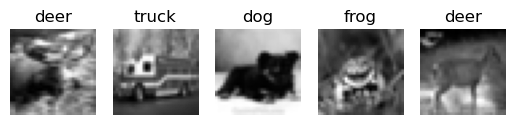

In [2]:
train_loader, val_loader = get_dataloaders(batch_size=128)
class_labels = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

# Draw one batch to show some training images
x, y = next(train_loader.__iter__())

fig, ax = plt.subplots(ncols=5)
for i in range(5):
    ax[i].imshow(x[i].cpu().numpy().transpose(1, 2, 0), cmap="gray")
    ax[i].axis("off")
    ax[i].set_title(class_labels[y[i]])

### Network architecture and training: tiny MLP

In [3]:
# dims = [32 * 32, 2048, 4096, 10]  
dims = [32 * 32, 512, 256, 10]
model = initialize_mlp_model(dims)
print(model)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=1024, out_features=512, bias=False)
  (2): ReLU()
  (3): Linear(in_features=512, out_features=256, bias=False)
  (4): ReLU()
  (5): Linear(in_features=256, out_features=10, bias=False)
)


In [4]:
train_model(model, train_loader, val_loader, num_epochs=5);

Val epoch 0:   0%|          | 0/79 [00:00<?, ?it/s]

Train epoch 1:   0%|          | 0/391 [00:00<?, ?it/s]

Val epoch 1:   0%|          | 0/79 [00:00<?, ?it/s]

Train epoch 2:   0%|          | 0/391 [00:00<?, ?it/s]

Val epoch 2:   0%|          | 0/79 [00:00<?, ?it/s]

Train epoch 3:   0%|          | 0/391 [00:00<?, ?it/s]

Val epoch 3:   0%|          | 0/79 [00:00<?, ?it/s]

Train epoch 4:   0%|          | 0/391 [00:00<?, ?it/s]

Val epoch 4:   0%|          | 0/79 [00:00<?, ?it/s]

Train epoch 5:   0%|          | 0/391 [00:00<?, ?it/s]

Val epoch 5:   0%|          | 0/79 [00:00<?, ?it/s]

### Analysis of activations

In [5]:
# Layers 3 and 5 correspond to the output of the two ReLUs.
layers = [3, 5]
activation_covariances = compute_activation_covariances(train_loader, layers, model)
# Activation covariances is a list of covariances, one per layer.

Computing activation covariance:   0%|          | 0/391 [00:00<?, ?it/s]

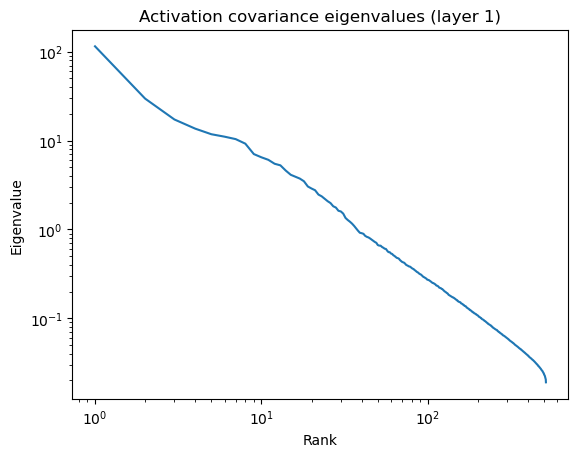

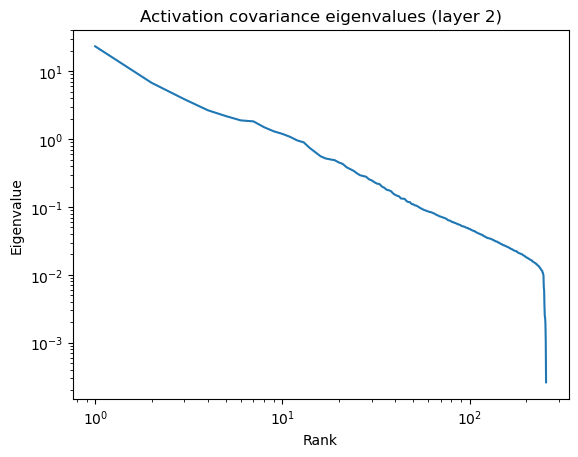

In [6]:
# Plot the eigenvalues of the activation covariances.
for layer_idx in range(2):
    activation_covariance = activation_covariances[layer_idx]
    activation_eigenvalues = torch.linalg.eigvalsh(activation_covariance).flip(-1)  # descending order
    
    # Log-log plot
    plt.title(f"Activation covariance eigenvalues (layer {layer_idx + 1})")
    y = activation_eigenvalues.cpu().numpy()
    x = 1 + np.arange(len(y))
    plt.plot(x, y)
    plt.yscale("log")
    plt.xscale("log")
    plt.xlabel("Rank")
    plt.ylabel("Eigenvalue")
    plt.show()

Evaluation after clipping:   0%|          | 0/79 [00:00<?, ?it/s]

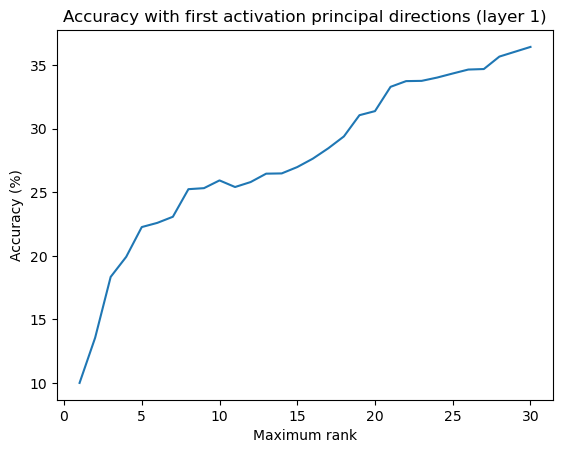

Evaluation after clipping:   0%|          | 0/79 [00:00<?, ?it/s]

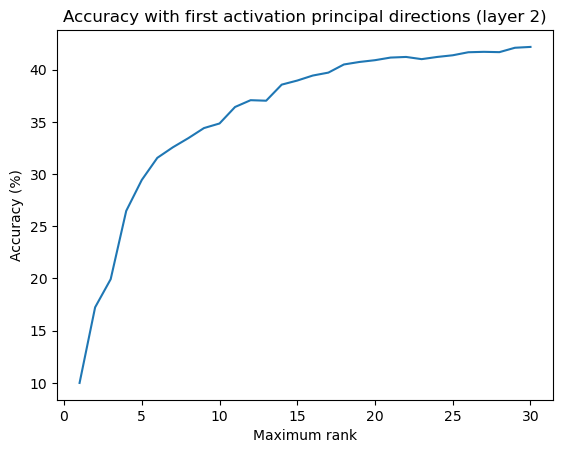

In [7]:
# Clipping analysis.
for layer_idx in range(2):
    activation_covariance = activation_covariances[layer_idx]
    basis = torch.linalg.eigh(activation_covariance).eigenvectors.flip(-1).T  # (num_eig, dim), descending order
    dimensions = list(range(1, 31))
    accuracies = clip(model, 2 * layer_idx + 3, basis, dimensions, val_loader)
    
    plt.figure()
    plt.plot(dimensions, accuracies)
    plt.title(f"Accuracy with first activation principal directions (layer {layer_idx + 1})")
    plt.xlabel("Maximum rank")
    plt.ylabel(r"Accuracy (%)")
    plt.show()

### Analysis of weights

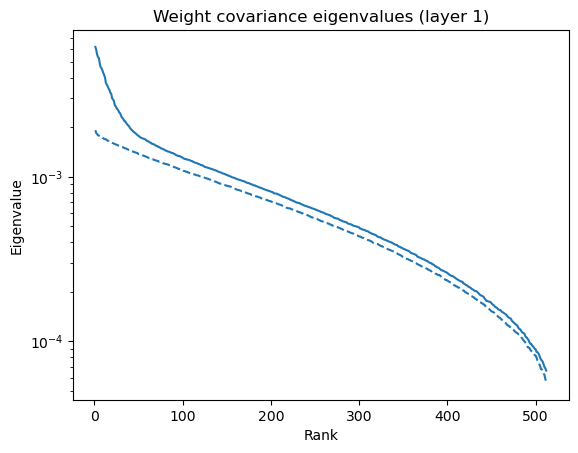

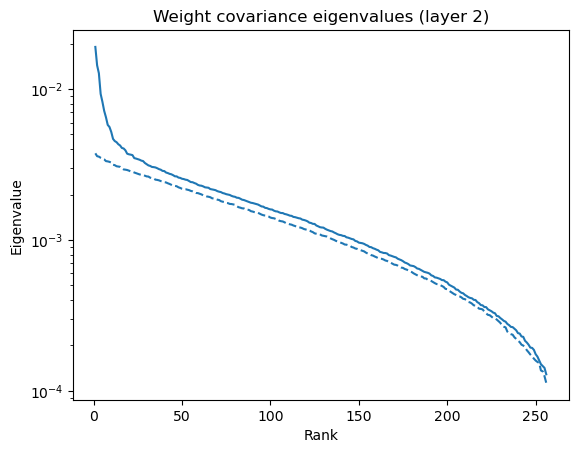

In [8]:
# Plot the eigenvalues of the weight covariances.
for layer_idx in range(2):
    weight_matrix = model[2 * layer_idx + 1].weight  # (N, D)
    # Compute eigenvalues of weight covariance efficiently from the SVD.
    weight_eigenvalues = torch.linalg.svdvals(weight_matrix) ** 2 / weight_matrix.shape[0]
    
    # Compare with eigenvalues at initialization.
    init_weight_matrix = initialize_mlp_model(dims)[2 * layer_idx + 1].weight
    init_eigenvalues = torch.linalg.svdvals(init_weight_matrix) ** 2 / weight_matrix.shape[0]
    
    # Log-lin plot
    plt.title(f"Weight covariance eigenvalues (layer {layer_idx + 1})")
    y = weight_eigenvalues.cpu().numpy()
    x = 1 + np.arange(len(y))
    plt.plot(x, y)
    plt.plot(x, init_eigenvalues.detach().cpu().numpy(), linestyle="dashed", color="C0")
    plt.yscale("log")
    plt.xlabel("Rank")
    plt.ylabel("Eigenvalue")
    plt.show()

Evaluation after clipping:   0%|          | 0/79 [00:00<?, ?it/s]

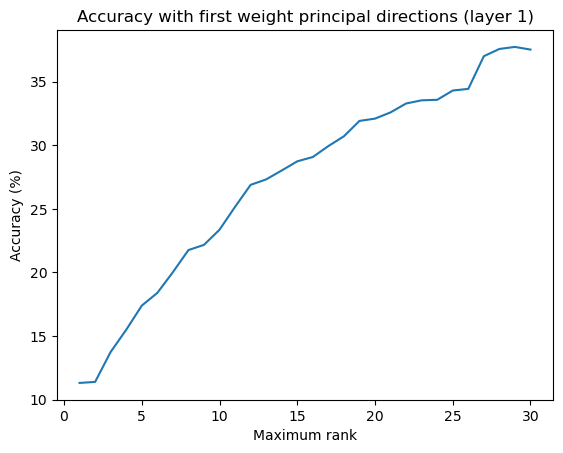

Evaluation after clipping:   0%|          | 0/79 [00:00<?, ?it/s]

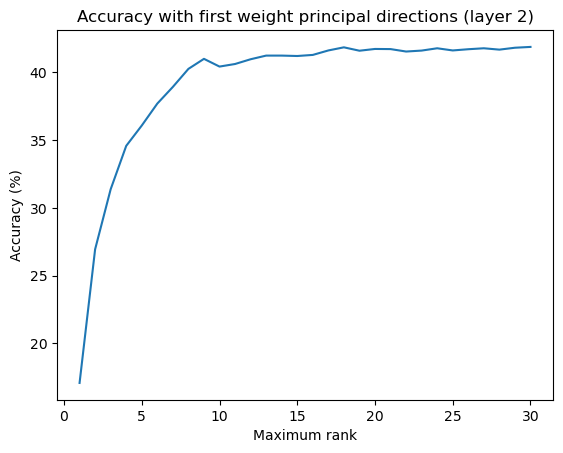

In [9]:
# Clipping analysis.
for layer_idx in range(2):
    weight_matrix = model[2 * layer_idx + 1].weight  # (N, D)
    # Compute eigenvalues of weight covariance efficiently from the SVD.
    basis = torch.linalg.svd(weight_matrix).Vh
    dimensions = list(range(1, 31))
    accuracies = clip(model, 2 * layer_idx + 1, basis, dimensions, val_loader)
    
    plt.figure()
    plt.plot(dimensions, accuracies)
    plt.title(f"Accuracy with first weight principal directions (layer {layer_idx + 1})")
    plt.xlabel("Maximum rank")
    plt.ylabel(r"Accuracy (%)")
    plt.show()

### Stability: second model

In [10]:
models = [model] + [train_model(initialize_mlp_model(dims), train_loader, val_loader, num_epochs=5)]

Val epoch 0:   0%|          | 0/79 [00:00<?, ?it/s]

Train epoch 1:   0%|          | 0/391 [00:00<?, ?it/s]

Val epoch 1:   0%|          | 0/79 [00:00<?, ?it/s]

Train epoch 2:   0%|          | 0/391 [00:00<?, ?it/s]

Val epoch 2:   0%|          | 0/79 [00:00<?, ?it/s]

Train epoch 3:   0%|          | 0/391 [00:00<?, ?it/s]

Val epoch 3:   0%|          | 0/79 [00:00<?, ?it/s]

Train epoch 4:   0%|          | 0/391 [00:00<?, ?it/s]

Val epoch 4:   0%|          | 0/79 [00:00<?, ?it/s]

Train epoch 5:   0%|          | 0/391 [00:00<?, ?it/s]

Val epoch 5:   0%|          | 0/79 [00:00<?, ?it/s]

In [11]:
model_layer_covs = [activation_covariances] + [compute_activation_covariances(train_loader, layers, models[1])]

Computing activation covariance:   0%|          | 0/391 [00:00<?, ?it/s]

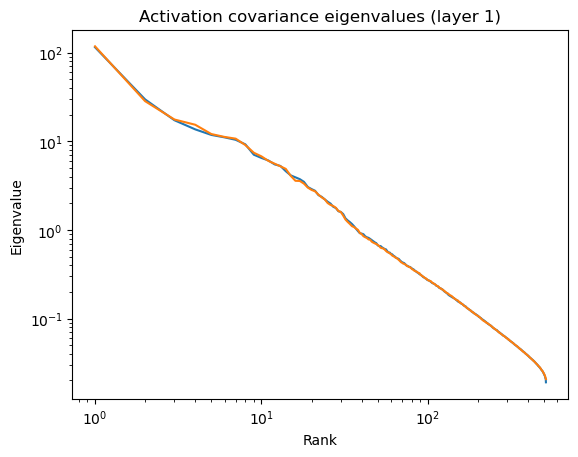

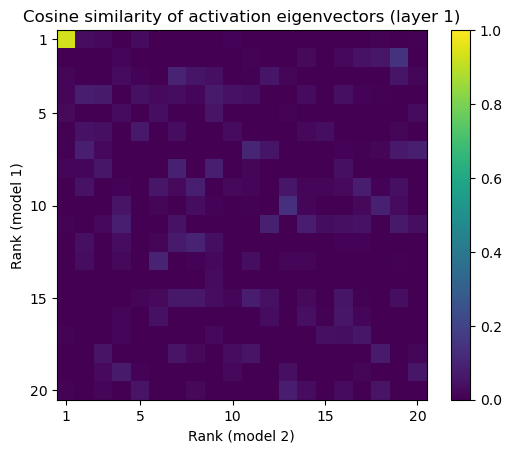

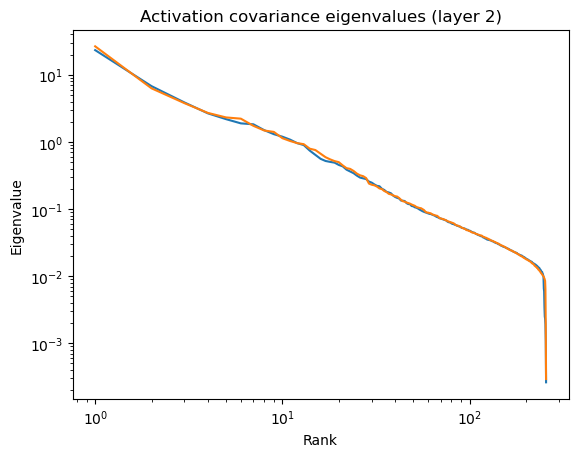

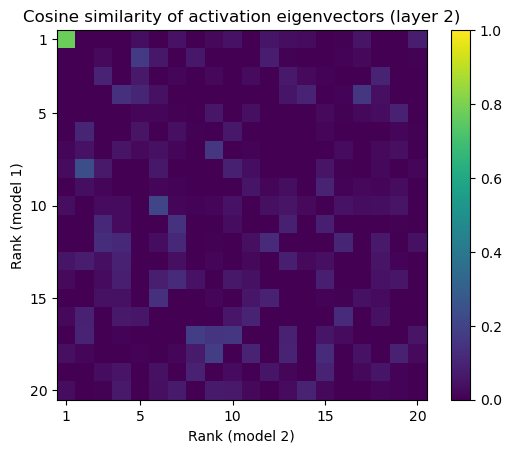

In [12]:
# Activations: compare spectra (stable) and eigenvectors (unstable because no alignment)
for j in range(2):
    spectra = []
    eigs = []
    for layer_covs in model_layer_covs:
        cov = layer_covs[j]  # (C, C)
        eigenvalues, eigenvectors = torch.linalg.eigh(cov)
        # Sort in descending order and transpose.
        eigenvalues, eigenvectors = eigenvalues.flip(-1), eigenvectors.flip(-1)
        eigenvectors = eigenvectors.T  # (R, D)
        spectra.append(eigenvalues)
        eigs.append(eigenvectors)
    
    plt.title(f"Activation covariance eigenvalues (layer {j + 1})")
    for spectrum in spectra:
        y = spectrum.cpu().numpy()
        x = 1 + np.arange(len(y))
        plt.plot(x, y)
    plt.yscale("log")
    plt.xscale("log")
    plt.xlabel("Rank")
    plt.ylabel("Eigenvalue")
    plt.show()
    
    stab = eigs[0] @ eigs[1].T  # (R, R)
    plt.imshow(stab.cpu().numpy()[:20, :20], cmap="viridis", vmin=0, vmax=1)
    plt.colorbar()
    plt.title(f"Cosine similarity of activation eigenvectors (layer {j + 1})")
    plt.xlabel("Rank (model 2)")
    plt.ylabel("Rank (model 1)")
    ticks = np.asarray([1, 5, 10, 15, 20])
    plt.xticks(ticks=ticks - 1, labels=[str(i) for i in ticks])
    plt.yticks(ticks=ticks - 1, labels=[str(i) for i in ticks])
    plt.show()

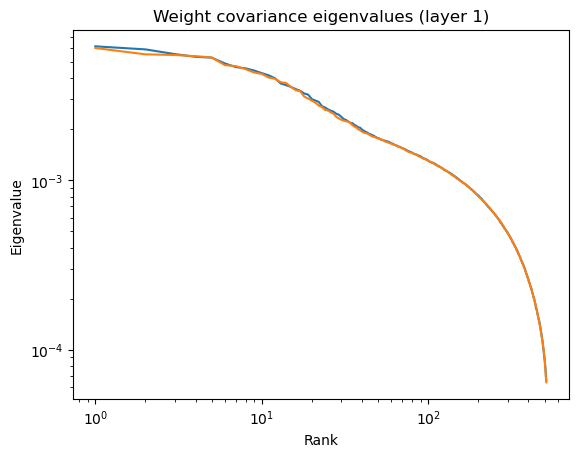

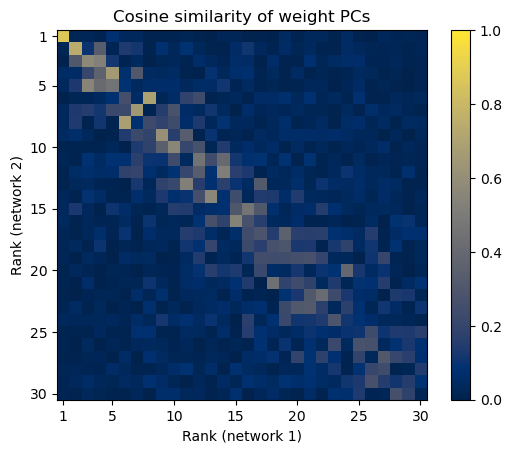

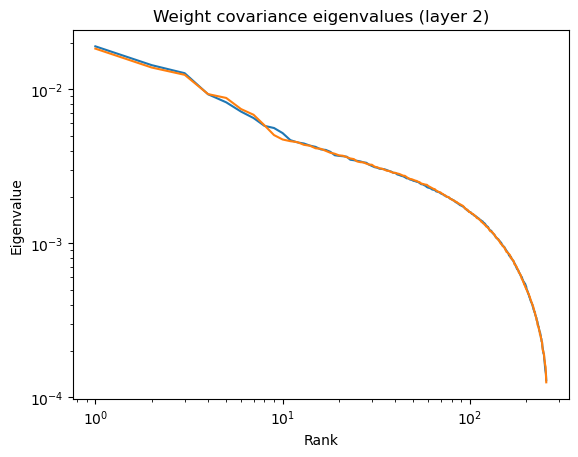

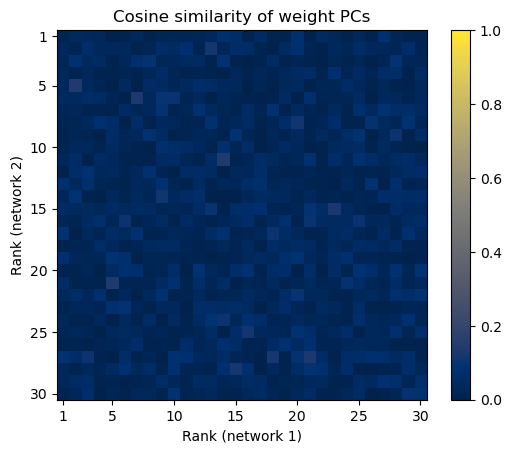

In [24]:
# Weights: compare spectra (stable) and eigenvectors (unstable after first layer because no alignment)
for j in range(2):
    spectra = []
    eigs = []
    for model in models:
        w = model[2 * j + 1].weight  # (N, D)
        u, s, vh = torch.linalg.svd(w, full_matrices=False)  # (N, R), (R,), (R, D)
        spectrum = s ** 2 / w.shape[0]
        spectra.append(spectrum)
        eigs.append(vh)
    
    plt.title(f"Weight covariance eigenvalues (layer {j + 1})")
    for spectrum in spectra:
        y = spectrum.cpu().numpy()
        x = 1 + np.arange(len(y))
        plt.plot(x, y)
    plt.yscale("log")
    plt.xscale("log")
    plt.xlabel("Rank")
    plt.ylabel("Eigenvalue")
    plt.show()
    
    stab = torch.abs(eigs[0] @ eigs[1].T)  # (R, R)
    plt.imshow(stab.cpu().numpy()[:30, :30], cmap="cividis", vmin=0, vmax=1)
    plt.colorbar()
    plt.title(f"Cosine similarity of weight PCs")
    plt.xlabel("Rank (network 1)")
    plt.ylabel("Rank (network 2)")
    ticks = np.asarray([1, 5, 10, 15, 20, 25, 30])
    plt.xticks(ticks=ticks - 1, labels=[str(i) for i in ticks])
    plt.yticks(ticks=ticks - 1, labels=[str(i) for i in ticks])
    plt.show()

### Alignment between two models

In [14]:
# Compute cross-covariance between model activations.
model1, model2 = models
cross_covs = compute_activation_covariances(train_loader, layers, model1, model2)
# cross_covs is a list of activation covariances (C1, C2) for each layer.

Computing activation covariance:   0%|          | 0/391 [00:00<?, ?it/s]

In [15]:
# Compute alignments between models with an SVD, and evaluate alignment accuracy (fraction of explained variance).
aligns = []  # layer_idx -> alignment
for j in range(2):
    cross_cov = cross_covs[j]
    u, s, vh = torch.linalg.svd(cross_cov, full_matrices=False)

    explained_variance = torch.sum(s)
    total_variance = torch.sqrt(torch.trace(model_layer_covs[0][j]) * torch.trace(model_layer_covs[1][j]))
    r_squared = explained_variance / total_variance
    print(f"Layer {j + 1}: {100 * r_squared.item():.1f}% of variance explained by alignment")
    # NOTE: r² should be computed on a test set to control for overfitting.
    
    align = u @ vh
    aligns.append(align)

Layer 1: 92.3% of variance explained by alignment
Layer 2: 87.9% of variance explained by alignment


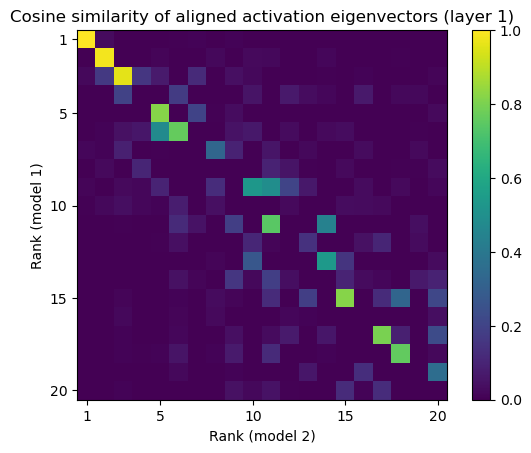

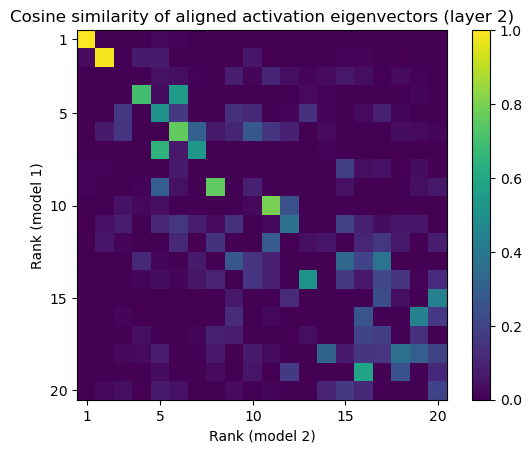

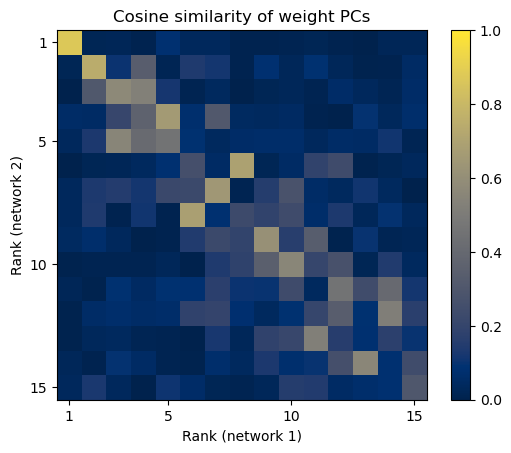

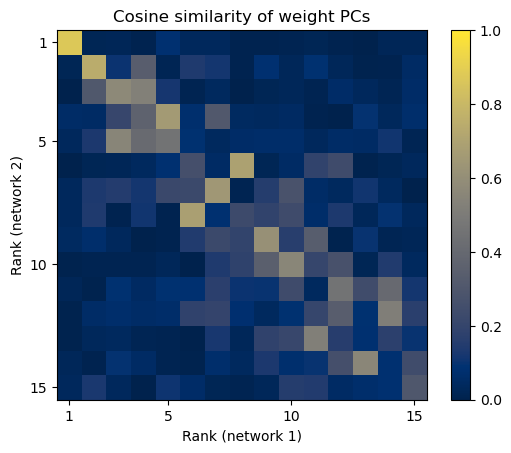

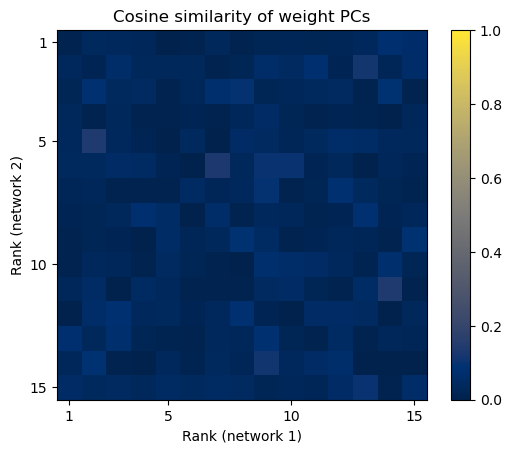

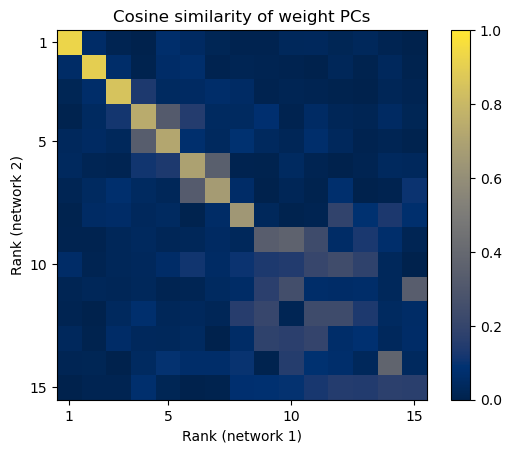

In [26]:
# Measure stability of activations eigenvectors after alignment.
for j in range(2):
    spectra = []
    eigs = []
    for layer_covs in model_layer_covs:
        cov = layer_covs[j]  # (C, C)
        eigenvalues, eigenvectors = torch.linalg.eigh(cov)
        # Sort in descending order and transpose.
        eigenvalues, eigenvectors = eigenvalues.flip(-1), eigenvectors.flip(-1)
        eigenvectors = eigenvectors.T  # (R, D)
        spectra.append(eigenvalues)
        eigs.append(eigenvectors)
    
    stab = eigs[0] @ aligns[j] @ eigs[1].T  # (R, R)
    plt.imshow(stab.cpu().numpy()[:20, :20], cmap="viridis", vmin=0, vmax=1)
    plt.title(f"Cosine similarity of aligned activation eigenvectors (layer {j + 1})")
    plt.xlabel("Rank (model 2)")
    plt.ylabel("Rank (model 1)")
    ticks = np.asarray([1, 5, 10, 15, 20])
    plt.xticks(ticks=ticks - 1, labels=[str(i) for i in ticks])
    plt.yticks(ticks=ticks - 1, labels=[str(i) for i in ticks])
    plt.colorbar()
    plt.show()

# Measure stability of weight eigenvectors of alignment.
for j in range(2):
    spectra = []
    eigs = []
    for model in models:
        w = model[2 * j + 1].weight  # (N, D)
        u, s, vh = torch.linalg.svd(w, full_matrices=False)  # (N, R), (R,), (R, D)
        spectrum = s ** 2 / w.shape[0]
        spectra.append(spectrum)
        eigs.append(vh)
    
    for aligned in [False, True]:
        if j == 0 or not aligned:
            stab = torch.abs(eigs[0] @ eigs[1].T)  # (R, R)
        elif j == 1:
            stab = torch.abs(eigs[0] @ aligns[0] @ eigs[1].T)  # (R, R)
        plt.imshow(stab.cpu().numpy()[:15, :15], cmap="cividis", vmin=0, vmax=1)
        plt.colorbar()
        plt.title(f"Cosine similarity of weight PCs")
        plt.xlabel("Rank (network 1)")
        plt.ylabel("Rank (network 2)")
        ticks = np.asarray([1, 5, 10, 15])
        plt.xticks(ticks=ticks - 1, labels=[str(i) for i in ticks])
        plt.yticks(ticks=ticks - 1, labels=[str(i) for i in ticks])
        plt.show()

### Resampling

In [17]:
state_dict_keys = list(model.state_dict().keys())
print(f"Resampling {state_dict_keys}")
reference_accuracy, resampled_accuracy = resample(model, state_dict_keys, train_loader, val_loader)
print(f"Accuracy after resampling: {resampled_accuracy:.1f}% (accuracy after training: {reference_accuracy:.1f}%)")

Resampling ['1.weight', '3.weight', '5.weight']


Computing activation covariance:   0%|          | 0/391 [00:00<?, ?it/s]

Computing activation covariance:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluation after resampling:   0%|          | 0/79 [00:00<?, ?it/s]

Accuracy after resampling: 30.6% (accuracy after training: 42.4%)


### CNN

The above analysis can be extended to a CNN by computing alignment over channels and reshaping weight tensors (C_out, C_in, h, w) as (C_out, C_in\*h\*w).
Note that resampling doesn't work as well, because the spatial filters are not well-approximated by a Gaussian.

In [18]:
channels = [1, 32, 64]
model = initialize_cnn_model(channels)
print(model)

Sequential(
  (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(2, 2), bias=False)
  (1): ReLU()
  (2): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2), bias=False)
  (3): ReLU()
  (4): Flatten(start_dim=1, end_dim=-1)
  (5): Linear(in_features=1600, out_features=10, bias=False)
)


In [19]:
train_model(model, train_loader, val_loader, num_epochs=5);

Val epoch 0:   0%|          | 0/79 [00:00<?, ?it/s]

Train epoch 1:   0%|          | 0/391 [00:00<?, ?it/s]

Val epoch 1:   0%|          | 0/79 [00:00<?, ?it/s]

Train epoch 2:   0%|          | 0/391 [00:00<?, ?it/s]

Val epoch 2:   0%|          | 0/79 [00:00<?, ?it/s]

Train epoch 3:   0%|          | 0/391 [00:00<?, ?it/s]

Val epoch 3:   0%|          | 0/79 [00:00<?, ?it/s]

Train epoch 4:   0%|          | 0/391 [00:00<?, ?it/s]

Val epoch 4:   0%|          | 0/79 [00:00<?, ?it/s]

Train epoch 5:   0%|          | 0/391 [00:00<?, ?it/s]

Val epoch 5:   0%|          | 0/79 [00:00<?, ?it/s]

In [20]:
state_dict_keys = list(model.state_dict().keys())
print(f"Resampling {state_dict_keys}")
reference_accuracy, resampled_accuracy = resample(model, state_dict_keys, train_loader, val_loader)
print(f"Accuracy after resampling: {resampled_accuracy:.1f}% (accuracy after training: {reference_accuracy:.1f}%)")

Resampling ['0.weight', '2.weight', '5.weight']


Computing activation covariance:   0%|          | 0/391 [00:00<?, ?it/s]

Computing activation covariance:   0%|          | 0/391 [00:00<?, ?it/s]

Evaluation after resampling:   0%|          | 0/79 [00:00<?, ?it/s]

Accuracy after resampling: 40.3% (accuracy after training: 57.4%)
